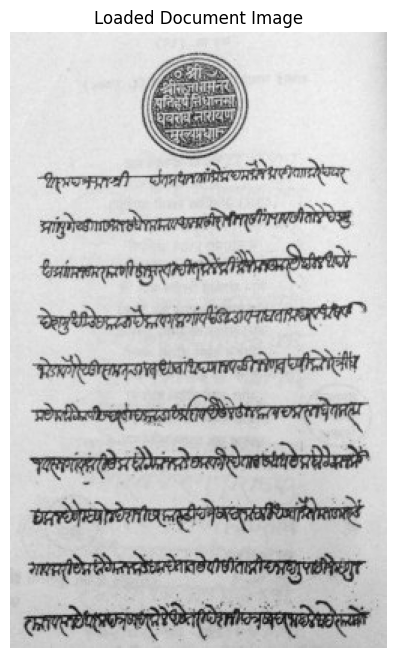

Image Dimensions: (411, 251)
Pixel Value Range: 28 to 190


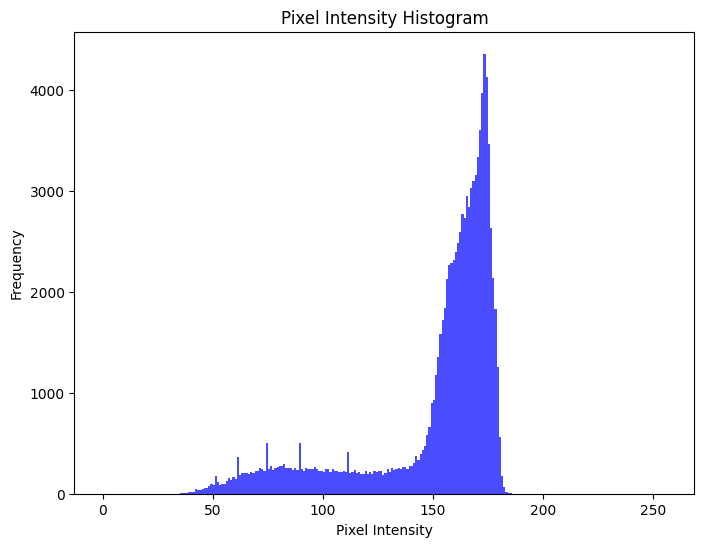

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def load_document_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Unable to load the image at {image_path}")
    return image

def display_image(image, title="Image"):
    """
    Function to display an image.
    Args:
        image (numpy.ndarray): Image to display.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def analyze_image_properties(image):
    """
    Analyze properties of the image.
    Args:
        image (numpy.ndarray): Input image.
    """
    print("Image Dimensions:", image.shape)
    print("Pixel Value Range:", np.min(image), "to", np.max(image))

    # Calculate and plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Load the image
image_path = 'historical-doc.png'  # Update this if needed
try:
    document_image = load_document_image(image_path)

    # Display the image
    display_image(document_image, title="Loaded Document Image")

    # Analyze the image properties
    analyze_image_properties(document_image)
except FileNotFoundError as e:
    print(e)

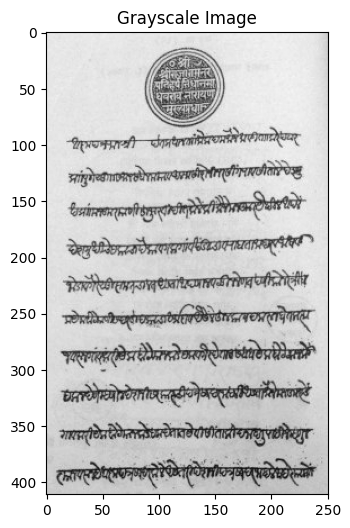

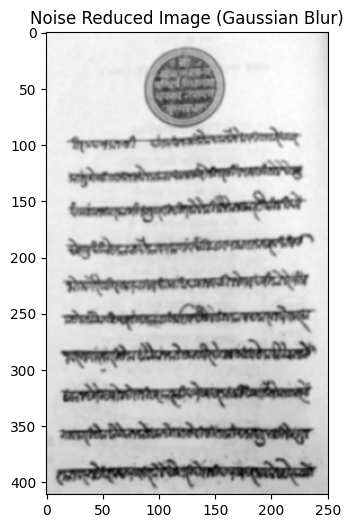

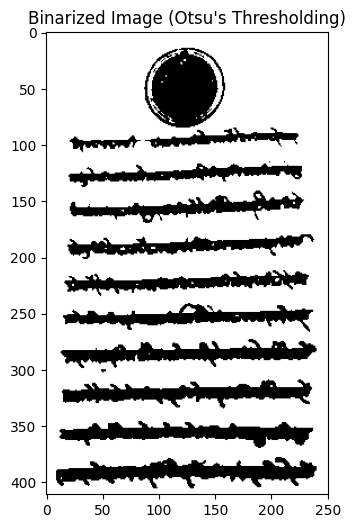

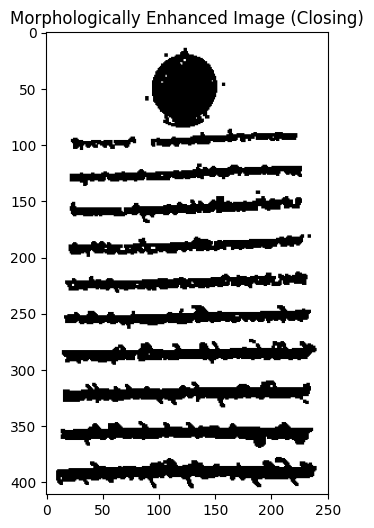

In [4]:

def preprocess_image(image):
    """
    Preprocess the document image to enhance it for text line detection.
    Steps include:
    - Grayscale conversion
    - Noise reduction using Gaussian blur
    - Binarization
    - Morphological operations
    """
    # Step 1: Grayscale Conversion
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(8, 6))
    plt.title("Grayscale Image")
    plt.imshow(gray_image, cmap="gray")
    plt.show()
    
    # Step 2: Noise Reduction
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    plt.figure(figsize=(8, 6))
    plt.title("Noise Reduced Image (Gaussian Blur)")
    plt.imshow(blurred_image, cmap="gray")
    plt.show()
    
    # Step 3: Binarization (Thresholding)
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.figure(figsize=(8, 6))
    plt.title("Binarized Image (Otsu's Thresholding)")
    plt.imshow(binary_image, cmap="gray")
    plt.show()
    
    # Step 4: Morphological Operations (Enhancing Text Lines)
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    plt.figure(figsize=(8, 6))
    plt.title("Morphologically Enhanced Image (Closing)")
    plt.imshow(morphed_image, cmap="gray")
    plt.show()
    
    return morphed_image

# Load the document image
image_path = "historical-doc.png"  # Replace with the correct path if needed
document_image = cv2.imread(image_path)

# Preprocess the image
preprocessed_image = preprocess_image(document_image)

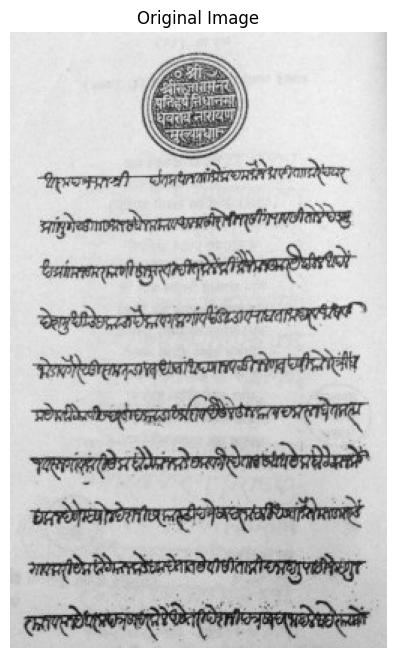

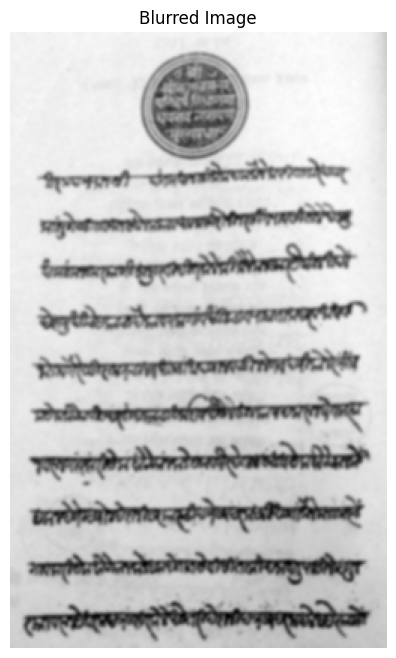

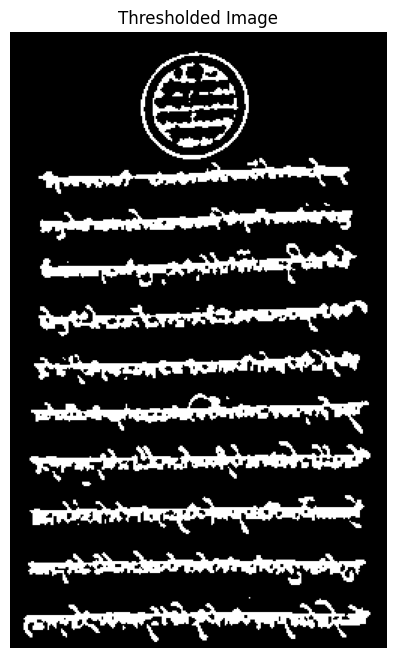

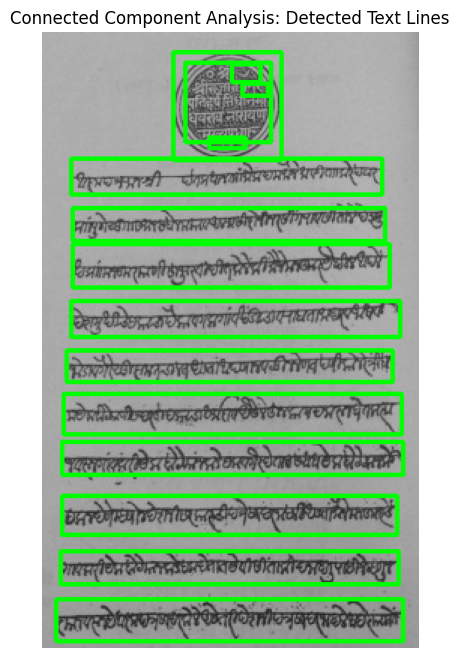

In [15]:
def detect_text_lines_cca(image_path):
    """
    Detects text lines using Connected Component Analysis (CCA) and draws bounding boxes.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        None
    """
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise reduction
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )
    
    # Connected Component Analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded_image, connectivity=8)
    
    # Draw bounding boxes on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i in range(1, num_labels):  # Skip background
        x, y, w, h, area = stats[i]
        if area > 50:  # Filter small components
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display the results
    plt.figure(figsize=(12, 8))
    plt.imshow(image,cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(blurred_image,cmap='gray')
    plt.title("Blurred Image")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(thresholded_image,cmap='gray')
    plt.title("Thresholded Image")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(output_image,cmap='gray')
    plt.title("Connected Component Analysis: Detected Text Lines")
    plt.axis("off")
    plt.show()
    
    return labels, stats

# Call the function
labels_cca, stats_cca = detect_text_lines_cca("historical-doc.png")

Justification (3.2.1)

Blurring done for noise artifact reduction and smoother text boundaries

Then usage of adaptive thresholding to ensure that lighting effects donot mess up the thresholding for the text to the background ( like they do for normal binary thresholding)

Then I ran connected component analysis for finding the statistics of where the connected components are located (in this case text) which are then fed to cv2.rectangle to draw the bounding boxes around these locations

The analysis for the performance of this seems to be great , I would say it did well except for the text inside the circular seal , especially since i didnt use any morphological operations on it yet

such a method could fail for text with no connected components (english words are separated by minute spacing simimlar to line spacing) in which case i would have to rely on dilation to connect text on the same line to draw appropriate bounding boxes

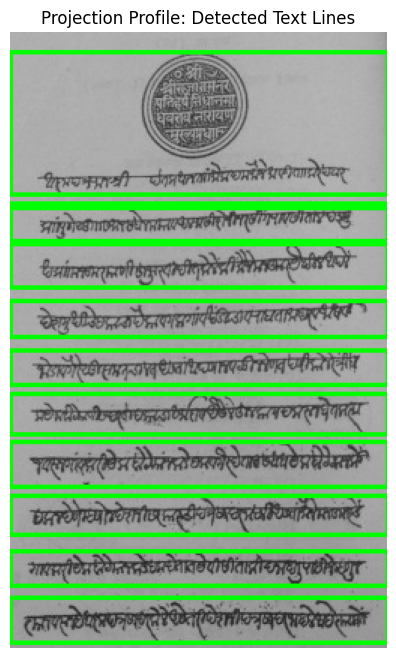

In [8]:
def detect_text_lines_projection(image_path):
    """
    Detects text lines using the horizontal projection profile method.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        None
    """
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise reduction
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )
    
    # Horizontal projection profile
    horizontal_projection = np.sum(thresholded_image == 255, axis=1)
    
    # Detect text lines based on peaks
    line_boundaries = []
    inside_line = False
    start_row = 0
    
    for i, value in enumerate(horizontal_projection):
        if value > 0 and not inside_line:  # Start of a line
            inside_line = True
            start_row = i
        elif value == 0 and inside_line:  # End of a line
            inside_line = False
            end_row = i
            line_boundaries.append((start_row, end_row))
    
    # Draw bounding boxes on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for start, end in line_boundaries:
        cv2.rectangle(output_image, (0, start), (image.shape[1], end), (0, 255, 0), 2)
    
    # Display the results
    plt.figure(figsize=(12, 8))
    plt.imshow(output_image)
    plt.title("Projection Profile: Detected Text Lines")
    plt.axis("off")
    plt.show()
    
    return line_boundaries

# Call the function
line_boundaries = detect_text_lines_projection("historical-doc.png")

Just a test of a different method to see if it fares any better for the circular seal text but unfortunately it doesnt

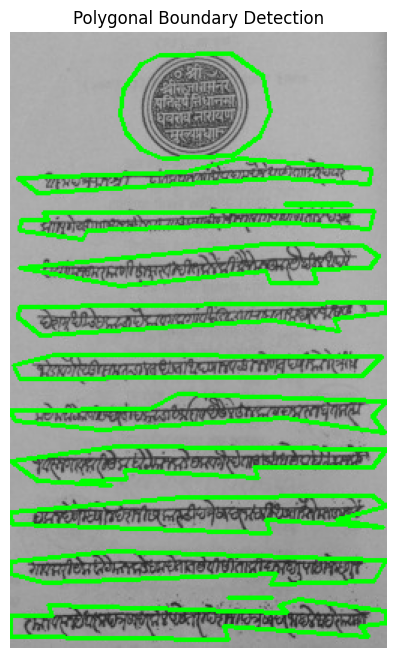

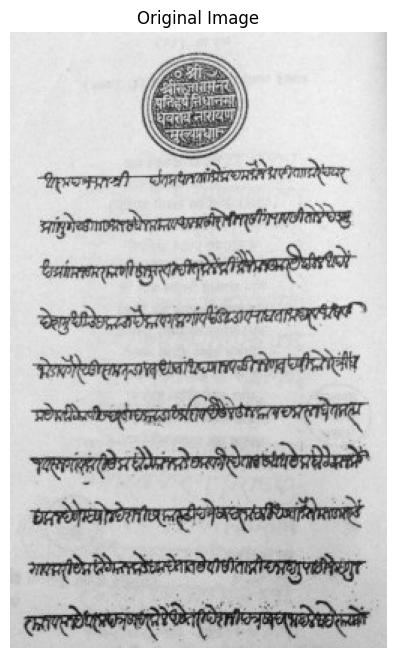

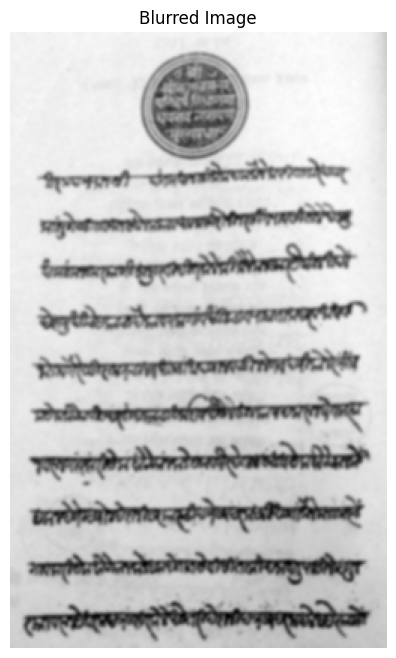

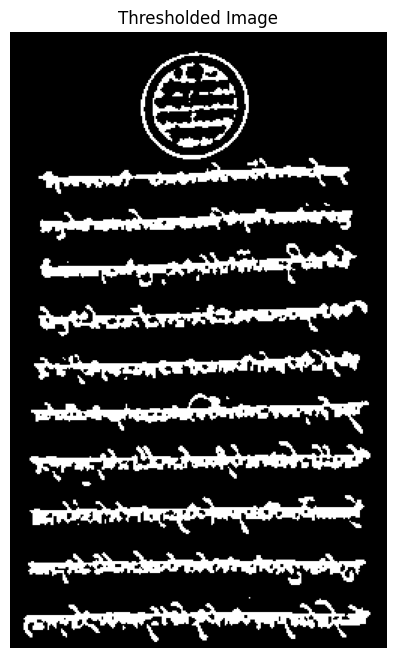

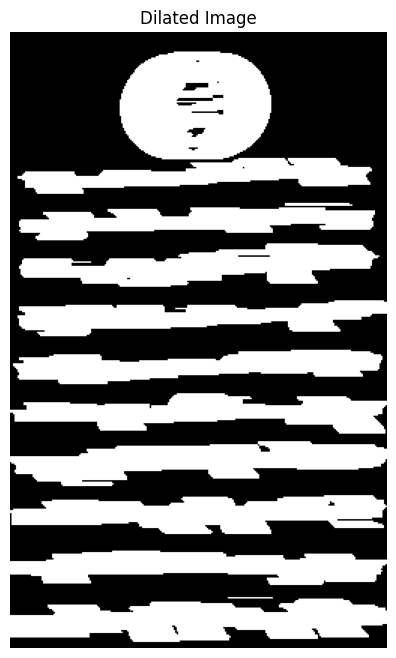

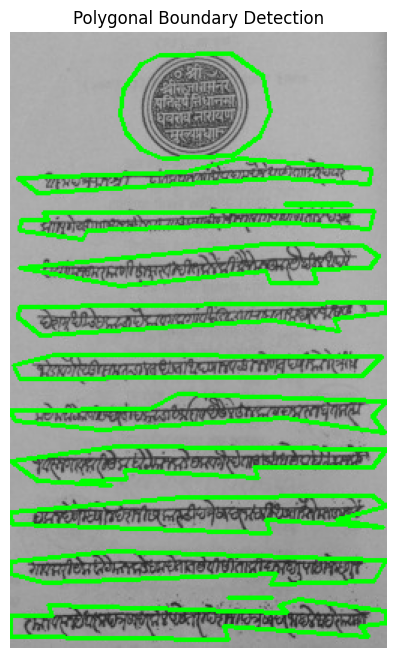

In [39]:
def detect_lines_with_polygons_with_display(image_path):
    """
    Detects text lines using polygonal boundaries and overlays them on the image.
    Displays each preprocessing step as an image.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        None
    """
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Display the original image
    plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    # Preprocess the image (Gaussian Blur + Adaptive Threshold)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    plt.figure(figsize=(12, 8))
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Blurred Image")
    plt.axis("off")
    plt.show()
    
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Thresholded Image")
    plt.axis("off")
    plt.show()
    
    # Morphological operations to emphasize text lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))  # Horizontal emphasis
    dilated = cv2.dilate(thresholded_image, kernel, iterations=1)
    plt.figure(figsize=(12, 8))
    plt.imshow(dilated, cmap='gray')
    plt.title("Dilated Image")
    plt.axis("off")
    plt.show()
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Approximate contours to polygons
    polygons = [cv2.approxPolyDP(cnt, epsilon=0.01 * cv2.arcLength(cnt, True), closed=True) for cnt in contours]
    
    # Draw polygons on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_image, polygons, -1, (0, 255, 0), 2)
    
    # Display the final result
    plt.figure(figsize=(12, 8))
    plt.imshow(output_image)
    plt.title("Polygonal Boundary Detection")
    plt.axis("off")
    plt.show()
    
    return polygons

# Call the function
polygons = detect_lines_with_polygons_with_display("historical-doc.png")

3.3

Now for advantages and disadvantages of Boundary boxes vs polygons,
Main advantage for polygon detection is that it is more precise and tightly bound to the text as compared to bounding boxes, which makes its computational complexity a disadvantage (also more prone to noisy morphological operation outputs)
Rectangle bounding box is computationally simpler as an advantage but also less precise 

Impact of using this was that it was more oriented towards detection of complex contours like the text displayed in this image.

Saved: output_lines\line_1.png
Saved: output_lines\line_2.png
Saved: output_lines\line_3.png
Saved: output_lines\line_4.png
Saved: output_lines\line_5.png
Saved: output_lines\line_6.png
Saved: output_lines\line_7.png
Saved: output_lines\line_8.png
Saved: output_lines\line_9.png
Saved: output_lines\line_10.png
Saved: output_lines\line_11.png
Saved: output_lines\line_12.png
Saved: output_lines\line_13.png
Saved: output_lines\line_14.png
Saved: output_lines\line_15.png


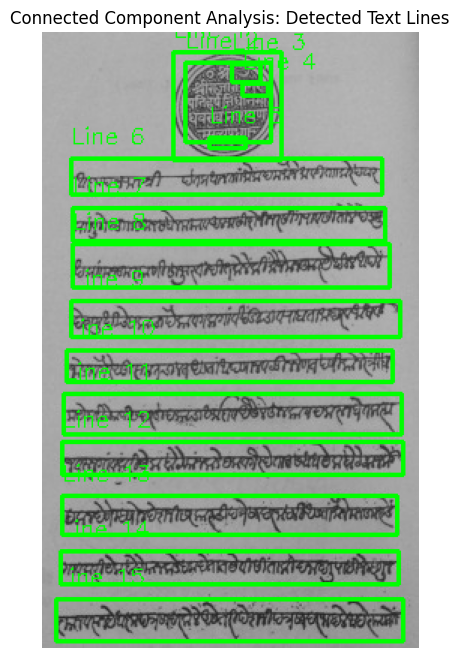

In [3]:
import os
def detect_text_lines_cca_with_save(image_path, save_dir="output_lines"):
    """
    Detects text lines using Connected Component Analysis (CCA), 
    draws bounding boxes, labels each line, and saves them as individual images.

    Parameters:
        image_path (str): Path to the image file.
        save_dir (str): Directory where the line images will be saved.
    
    Returns:
        None
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Noise reduction
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Connected Component Analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded_image, connectivity=8)

    # Draw bounding boxes on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    line_counter = 1

    for i in range(1, num_labels):  # Skip background (label 0)
        x, y, w, h, area = stats[i]
        if area > 50:  # Filter small components
            # Draw rectangle on the image
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Label the line
            cv2.putText(
                output_image, f"Line {line_counter}", (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
            )

            # Crop the line and save as a separate image
            line_image = image[y:y + h, x:x + w]
            line_save_path = os.path.join(save_dir, f"line_{line_counter}.png")
            cv2.imwrite(line_save_path, line_image)
            print(f"Saved: {line_save_path}")

            line_counter += 1

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(output_image, cmap='gray')
    plt.title("Connected Component Analysis: Detected Text Lines")
    plt.axis("off")
    plt.show()

# Call the function
detect_text_lines_cca_with_save("historical-doc.png")

Just saving the lines detected from the cca 

Really messing up inside the circular seal....

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png


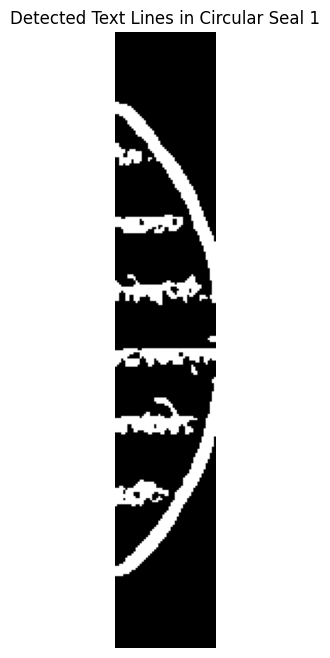

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png


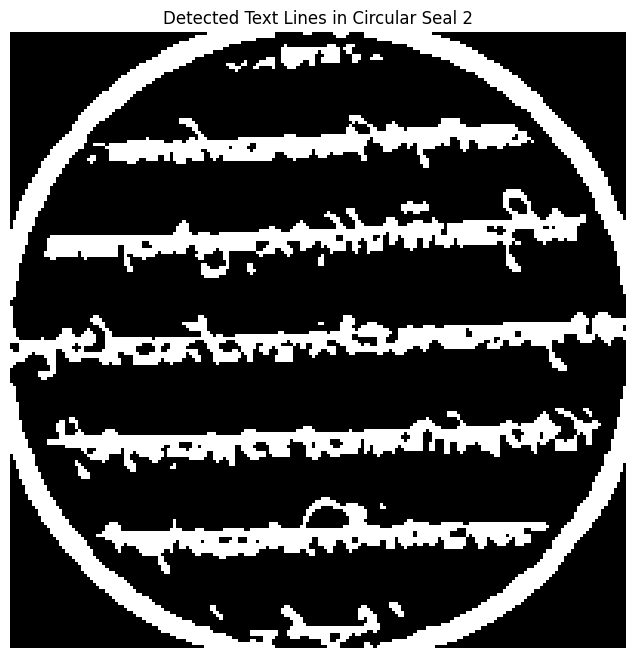

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png


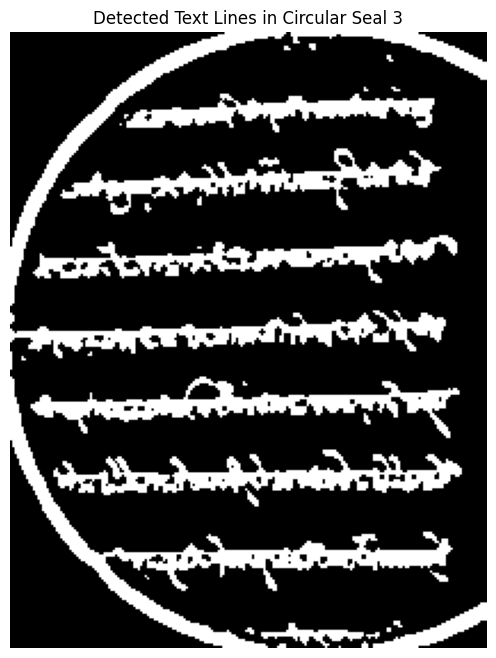

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png


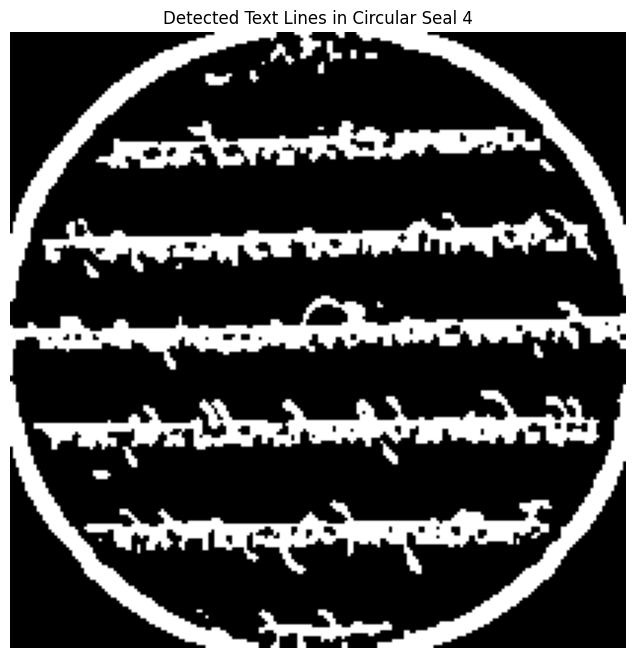

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png


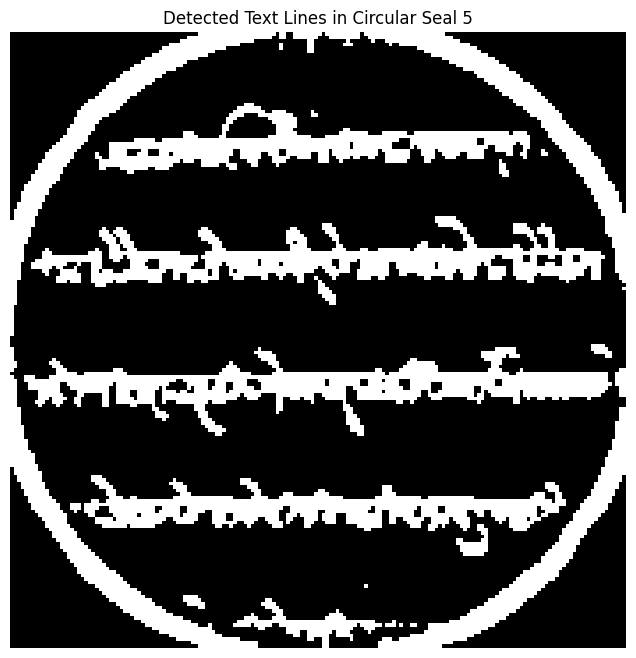

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png
Saved: circular_lines\circular_line_12.png
Saved: circular_lines\circular_line_13.png


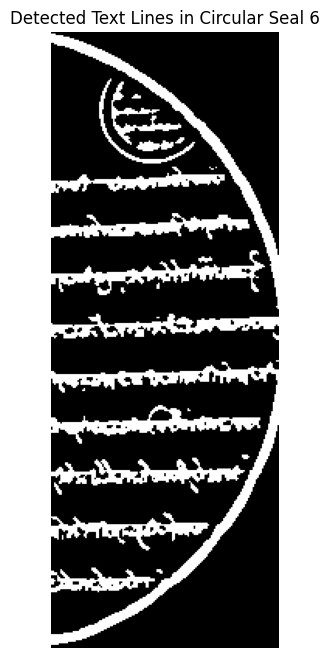

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png
Saved: circular_lines\circular_line_12.png
Saved: circular_lines\circular_line_13.png


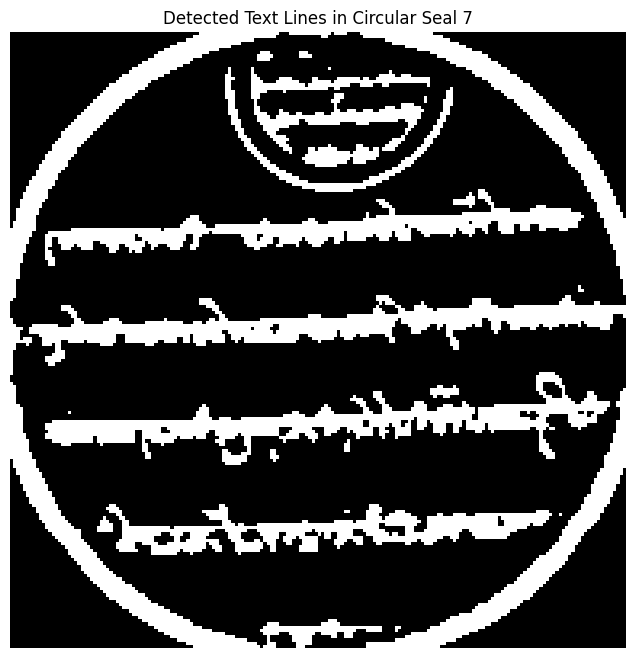

Saved: circular_lines\circular_line_1.png
Saved: circular_lines\circular_line_2.png
Saved: circular_lines\circular_line_3.png
Saved: circular_lines\circular_line_4.png
Saved: circular_lines\circular_line_5.png
Saved: circular_lines\circular_line_6.png
Saved: circular_lines\circular_line_7.png
Saved: circular_lines\circular_line_8.png
Saved: circular_lines\circular_line_9.png
Saved: circular_lines\circular_line_10.png
Saved: circular_lines\circular_line_11.png
Saved: circular_lines\circular_line_12.png
Saved: circular_lines\circular_line_13.png
Saved: circular_lines\circular_line_14.png
Saved: circular_lines\circular_line_15.png
Saved: circular_lines\circular_line_16.png


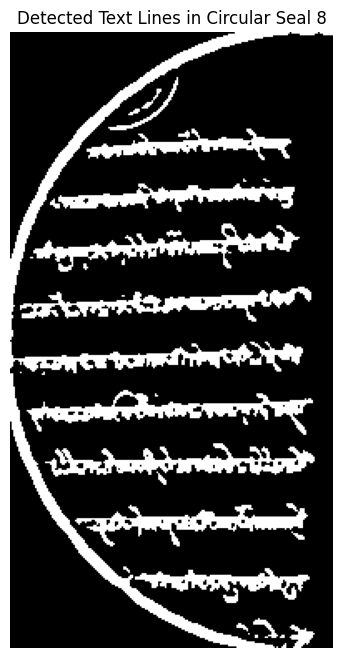

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:618: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [4]:
def detect_text_in_circular_seal(image_path, save_dir="circular_lines"):
    """
    Detects and saves text lines within a circular seal in an image.

    Parameters:
        image_path (str): Path to the input image file.
        save_dir (str): Directory to save the detected text lines.

    Returns:
        None
    """
    # Create the save directory
    os.makedirs(save_dir, exist_ok=True)

    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
        param1=100, param2=30, minRadius=50, maxRadius=200
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for i, (x, y, r) in enumerate(circles):
            # Create a circular mask
            mask = np.zeros_like(gray, dtype=np.uint8)
            cv2.circle(mask, (x, y), r, 255, -1)

            # Apply the mask to focus on the circular seal
            circular_region = cv2.bitwise_and(gray, gray, mask=mask)

            # Crop the region of interest (ROI) around the circle
            roi = circular_region[y - r:y + r, x - r:x + r]

            # Zoom in for text detection
            blurred_roi = cv2.GaussianBlur(roi, (5, 5), 0)
            thresholded_roi = cv2.adaptiveThreshold(
                blurred_roi, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
            )

            # Connected Component Analysis (CCA) for text lines
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded_roi, connectivity=8)
            line_counter = 1

            for j in range(1, num_labels):  # Skip background
                x2, y2, w, h, area = stats[j]
                if area > 30:  # Filter small components
                    # Crop the detected line
                    line_image = roi[y2:y2 + h, x2:x2 + w]
                    line_save_path = os.path.join(save_dir, f"circular_line_{line_counter}.png")
                    cv2.imwrite(line_save_path, line_image)
                    print(f"Saved: {line_save_path}")
                    line_counter += 1

            # Display the circular seal with detected text lines
            plt.figure(figsize=(8, 8))
            plt.imshow(thresholded_roi, cmap='gray')
            plt.title(f"Detected Text Lines in Circular Seal {i + 1}")
            plt.axis("off")
            plt.show()

    else:
        print("No circular seal detected in the image!")

# Call the function
detect_text_in_circular_seal("historical-doc.png")

The above implementation didnt work so im retrying the circular thing again

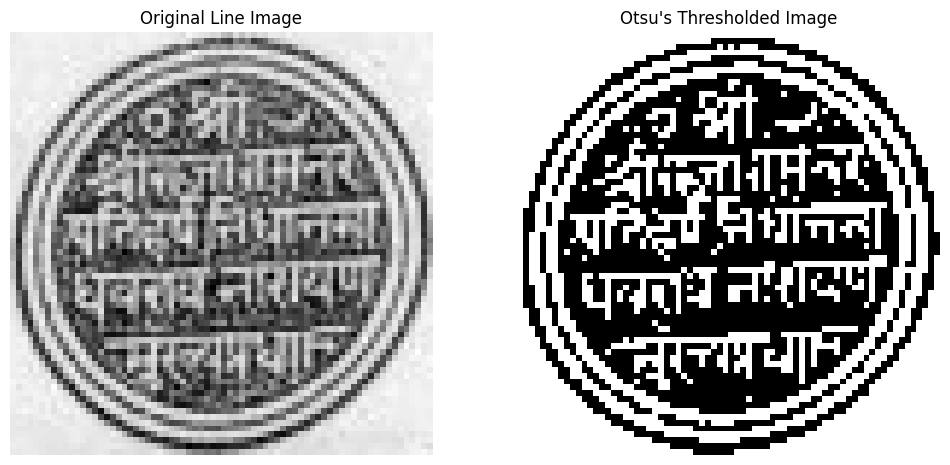

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the image
line_image_path = 'output_lines/line_1.png'  # Update this path if needed
line_image = cv2.imread(line_image_path, cv2.IMREAD_GRAYSCALE)

# Apply Otsu's thresholding
_, otsu_thresholded_image = cv2.threshold(line_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the original and thresholded images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(line_image, cmap='gray')
plt.title('Original Line Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.show()

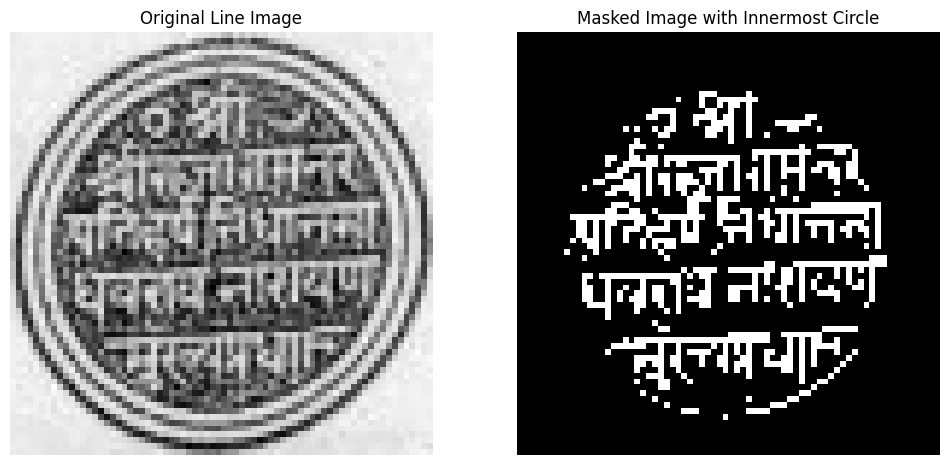

In [16]:
# Detect circles using Hough Circle Transform
import numpy as np
circles = cv2.HoughCircles(
    line_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
    param1=150, param2=40, minRadius=25, maxRadius=30
)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    # Select the innermost circle (smallest radius)
    innermost_circle = min(circles, key=lambda c: c[2])
    x, y, r = innermost_circle

    # Create a mask for the innermost circle
    mask = np.zeros_like(line_image, dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)

    # Apply the mask to the thresholded image
    masked_image = cv2.bitwise_and(otsu_thresholded_image, otsu_thresholded_image, mask=mask)

    # Make everything outside the circle background (set to 0)
    background = cv2.bitwise_not(mask)
    masked_image[background == 255] = 0

    # Display the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(line_image, cmap='gray')
    plt.title('Original Line Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masked_image, cmap='gray')
    plt.title('Masked Image with Innermost Circle')
    plt.axis('off')

    plt.show()
else:
    print("No circles detected in the image!")

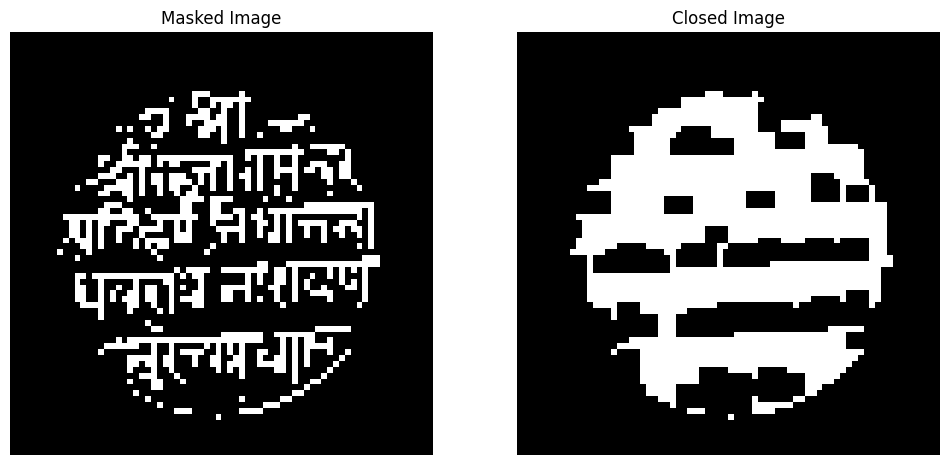

In [30]:
# Define the kernel for the morphological operation
kernel = np.ones((3, 4), np.uint8)

# Perform the closing operation
closed_image = cv2.morphologyEx(masked_image, cv2.MORPH_CLOSE, kernel)

# Display the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closed_image, cmap='gray')
plt.title('Closed Image')
plt.axis('off')

plt.show()

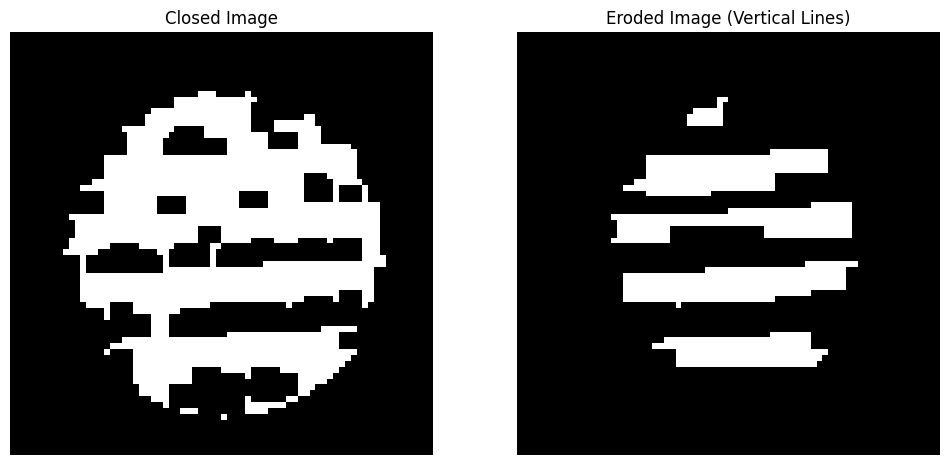

In [32]:
# Define the kernel for eroding vertical lines
vertical_kernel = np.ones((1, 5), np.uint8)

# Perform the erosion operation
eroded_image = cv2.erode(closed_image, vertical_kernel, iterations=3)

# Display the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(closed_image, cmap='gray')
plt.title('Closed Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(eroded_image, cmap='gray')
plt.title('Eroded Image (Vertical Lines)')
plt.axis('off')

plt.show()

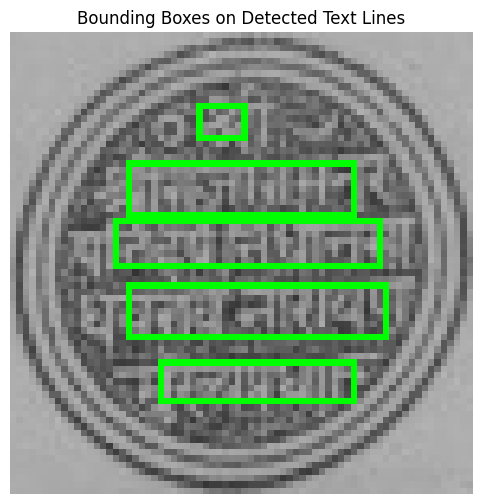

In [34]:
# Find contours in the eroded image
contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on the original line image
output_image = cv2.cvtColor(line_image, cv2.COLOR_GRAY2BGR)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(output_image)
plt.title('Bounding Boxes on Detected Text Lines')
plt.axis('off')
plt.show()

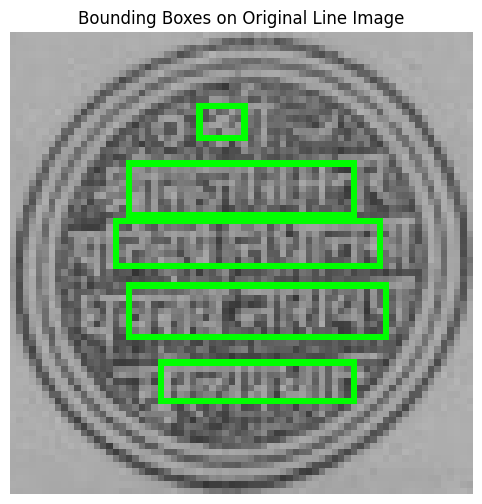

In [35]:
# Initialize a list to store the box coordinates
box_coordinates = []

# Draw bounding boxes on the original line image and save the coordinates
output_image_with_boxes = cv2.cvtColor(line_image, cv2.COLOR_GRAY2BGR)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    box_coordinates.append((x, y, w, h))
    cv2.rectangle(output_image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Save the box coordinates to a file
with open('box_coordinates.txt', 'w') as f:
    for coord in box_coordinates:
        f.write(f"{coord}\n")

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(output_image_with_boxes)
plt.title('Bounding Boxes on Original Line Image')
plt.axis('off')
plt.show()

In [36]:
import os

# Create the save directory if it doesn't exist
save_dir = "circular_seal_lines"
os.makedirs(save_dir, exist_ok=True)

# Crop and save each line
for i, (x, y, w, h) in enumerate(box_coordinates):
    cropped_line = line_image[y:y + h, x:x + w]
    save_path = os.path.join(save_dir, f"line_{i + 1}.png")
    cv2.imwrite(save_path, cropped_line)
    print(f"Saved: {save_path}")

Saved: circular_seal_lines\line_1.png
Saved: circular_seal_lines\line_2.png
Saved: circular_seal_lines\line_3.png
Saved: circular_seal_lines\line_4.png
Saved: circular_seal_lines\line_5.png


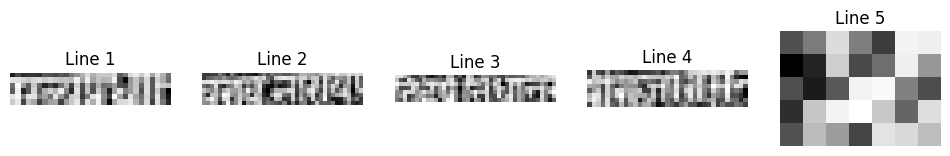

In [38]:
# Display the cropped lines
plt.figure(figsize=(12, 8))

for i, (x, y, w, h) in enumerate(box_coordinates):
    cropped_line = line_image[y:y + h, x:x + w]
    plt.subplot(1, len(box_coordinates), i + 1)
    plt.imshow(cropped_line, cmap='gray')
    plt.title(f'Line {i + 1}')
    plt.axis('off')

plt.show()

3.2.2 done 

with this I am done with the circular seal text detection 

Main challenges faced doing this was finding the correct parameters to segment out the seal (in Houghs transform) then finding the correct kernel dimensions to close erode to get recognisable separate lines (since the resolution of image is so low , doing such operations is very hard)